# Humidity Quantiles
Looks at how the bucket depth, specific humidity and relative humidity vary with quantile of surface temperature.

In [1]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, epsilon, L_v, c_p, g, R_v
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm

2023-02-10 11:06:32,393 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'bucket_depth']        # only keep variables required to compute relative humidity and MSE
# Load dataset
exp_dir = 'tau_sweep/land/meridional_band/bucket/'
tau_lw_ref = 1
tau_lw_warm = 2
exp_names = [f'k={tau_lw_ref}', f'k={tau_lw_warm}']
exp_names.sort()
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

max_bucket_depth_land = namelist['idealized_moist_phys_nml']['max_bucket_depth_land']

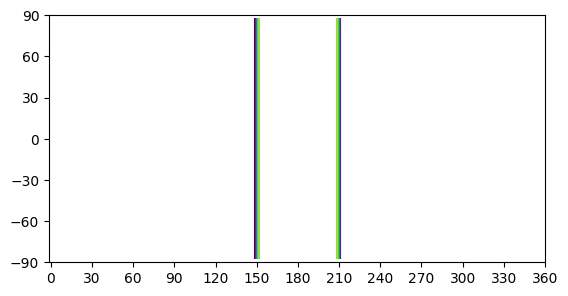

In [3]:
# Show where the land is
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Get datasets
Get one dataset, `ds_quant`, for land, for each latitude bin averaged over all days exceeding a given percentile in near surface air temperature.

Get another dataset, `ds_summer`, which is averaged over the ocean summer for a given latitude bin.

In [4]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2
# Tropics
lat_min = 0
lat_max = 20
# Extratropics
# lat_min = 30
# lat_max = 60

ds_all = {'land':[], 'ocean': []}
ds_summer = []
lon = {}
lon['land'] = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]
lon['ocean'] = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[1]
with tqdm(total=n_exp*2, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for surf in ['land', 'ocean']:
            ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
            ds_use = ds_use.sel(lon=np.unique(lon[surf]), method='nearest')
            ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)
            ds_all[surf] += [ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))]
            ds_all[surf][i].load()
            if surf == 'ocean':
                ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [6, 7, 8]).sel(lat=slice(lat_min, lat_max))    # NH summer is JJA
                ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [12, 1, 2]).sel(lat=slice(-lat_max, -lat_min))    # SH summer is DJF
                # Combine hemispheres and average over longitude, time and latitude.
                ds_use = xr.concat([ds_nh_summer, ds_sh_summer], dim='lat')
                ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
                ds_summer += [ds_use]
                ds_summer[i].load()
            pbar.update(1)

100%|██████████| 4/4 [00:33<00:00,  8.48s/it]


## Bucket Depth
This looks at how the average bucket depth varies when averaged over different temperature percentiles.

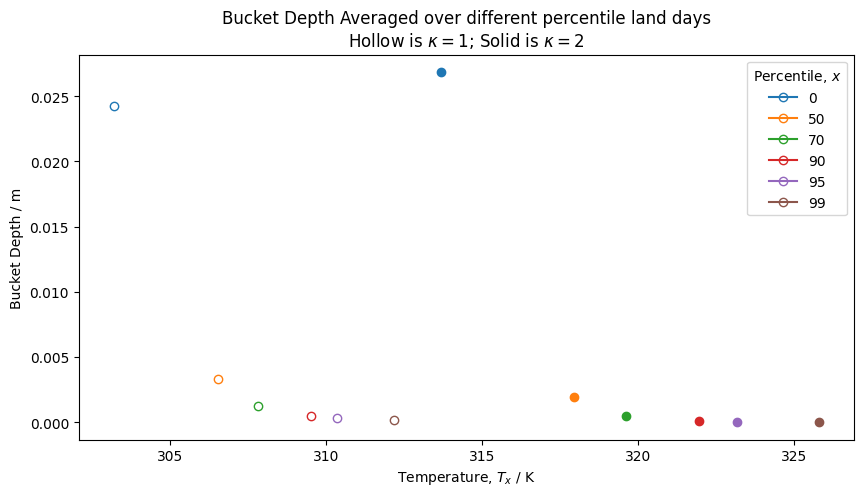

In [5]:
# Plot mean bucket depth averaged over different quantiles of land surface temperature
def get_quant_ind(dataset, percentile):
    # Function to find indices in dataset corresponding to surface temperature above a given quantile
    quantile_thresh = dataset.temp.quantile(percentile/100, dim='lon_lat_time', keep_attrs=True)
    quant_ind = np.where(dataset.temp > quantile_thresh)[0]
    return quant_ind

quant_plot = np.concatenate([[0], np.arange(50, 100, 20), [95, 99]])
fig, ax = plt.subplots(1,1, figsize=(10, 5))
for i in range(n_exp):
    for j, quant in enumerate(quant_plot):
        use_ind = get_quant_ind(ds_all['land'][i], quant)
        temp_mean = np.mean(ds_all['land'][i].temp[use_ind])
        bucket_depth_mean = np.mean(ds_all['land'][i].bucket_depth[use_ind])
        if i == 0:
            ax.plot(temp_mean, bucket_depth_mean, marker='o', fillstyle='none', label=quant)
        else:
            ax.plot(temp_mean, bucket_depth_mean, marker='o', color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j])
ax.legend(title='Percentile, $x$')
ax.set_xlabel('Temperature, $T_x$ / K')
ax.set_ylabel('Bucket Depth / m')
ax.set_title(f'Bucket Depth Averaged over different percentile land days\n'
             f'Hollow is $\kappa = {tau_lw_ref}$; Solid is $\kappa={tau_lw_warm}$');

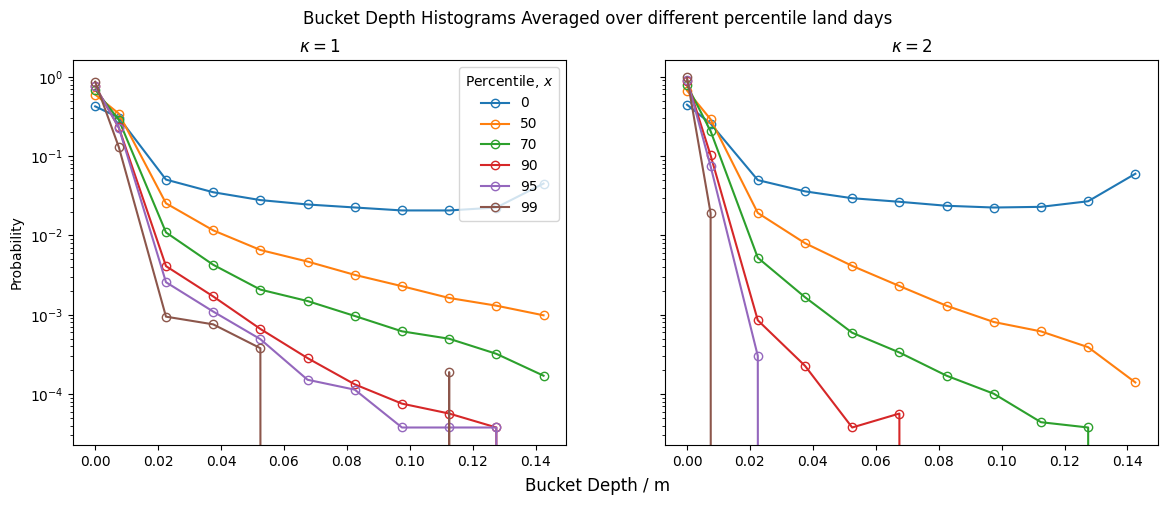

In [6]:
# Plot bucket depth histograms averaged over different quantiles of land surface temperature
n_bins = 10
# Have first bin be very narrow and centered on 0 so records amount of 0 bucket depths
bins = np.concatenate([[-max_bucket_depth_land/1e5, max_bucket_depth_land/1e5],
                       np.linspace(max_bucket_depth_land/n_bins, max_bucket_depth_land, n_bins)])
bin_centres = np.convolve(bins, np.ones(2)/2, mode='valid')
fig, ax = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
for i in range(n_exp):
    for quant in quant_plot:
        bin_counts = np.histogram(ds_all['land'][i].bucket_depth[get_quant_ind(ds_all['land'][i], quant)], bins=bins)[0]
        ax[i].plot(bin_centres, bin_counts/np.sum(bin_counts), marker='o', fillstyle='none', label=quant)
        ax[i].set_title(f'$\kappa = {tau_lw[i]}$')
ax[0].set_yscale('log')
ax[0].legend(title='Percentile, $x$')
ax[0].set_ylabel('Probability')
fig.supxlabel('Bucket Depth / m')
fig.suptitle('Bucket Depth Histograms Averaged over different percentile land days');
# ax[0].set_ylim([1e-3, 1.1]);

From these plots, we see that the mode bucket depth is 0 (the first bin only contains values that are 0) for all quantiles, indicating that the land is almost always dried out.

The plot below shows a 2D histogram indicating the relationship between bucket depth and temperature. It shows that for any given temperature, the most likely bucket depth is 0m or 0.008m (except for the 299K bin).


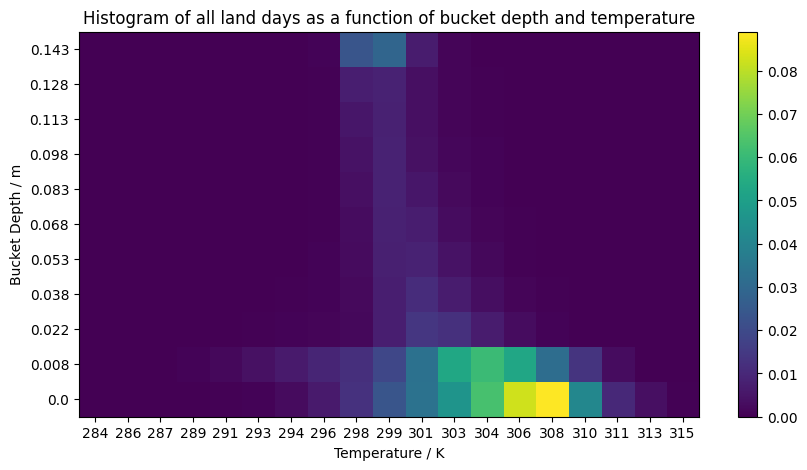

In [7]:
temp_bins = np.linspace(ds_all['land'][0].temp.min(), ds_all['land'][0].temp.max(), 20)
hist = np.histogram2d(ds_all['land'][0].temp, ds_all['land'][0].bucket_depth, bins=[temp_bins, bins])[0]

fig, ax = plt.subplots(1,1, figsize=(10, 5))
im = plt.imshow(hist.T/hist.sum(), origin='lower', aspect='auto')
ax.set_xticks(range(hist.shape[0]))
ax.set_xticklabels(np.round(np.convolve(temp_bins, np.ones(2)/2, mode='valid'), 0).astype(int))
ax.set_yticks(range(hist.shape[1]))
ax.set_yticklabels(np.round(bin_centres, 3))
fig.colorbar(im)
ax.set_ylabel('Bucket Depth / m')
ax.set_xlabel('Temperature / K')
ax.set_title('Histogram of all land days as a function of bucket depth and temperature');

## Specific Humidity


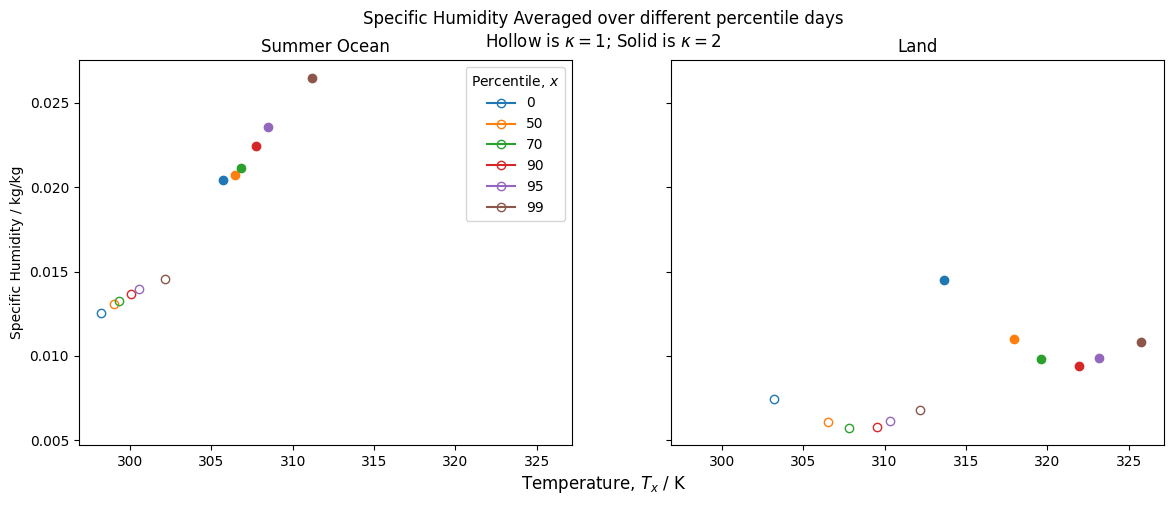

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
surfaces = ['ocean', 'land']
temp_quant = {'ocean': np.zeros((n_exp, len(quant_plot))), 'land': np.zeros((n_exp, len(quant_plot)))}
sphum_quant = {'ocean': np.zeros((n_exp, len(quant_plot))), 'land': np.zeros((n_exp, len(quant_plot)))}
for k, ds_use in enumerate([ds_summer, ds_all['land']]):
    for i in range(n_exp):
        for j, quant in enumerate(quant_plot):
            use_ind = get_quant_ind(ds_use[i], quant)
            temp_quant[surfaces[k]][i, j] = np.mean(ds_use[i].temp[use_ind])
            sphum_quant[surfaces[k]][i, j] = np.mean(ds_use[i].sphum[use_ind])
            if i == 0:
                ax[k].plot(temp_quant[surfaces[k]][i, j], sphum_quant[surfaces[k]][i, j], marker='o', fillstyle='none', label=quant)
            else:
                ax[k].plot(temp_quant[surfaces[k]][i, j], sphum_quant[surfaces[k]][i, j], marker='o',
                           color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j])
ax[0].legend(title='Percentile, $x$')
ax[0].set_title('Summer Ocean')
ax[1].set_title('Land')
fig.supxlabel('Temperature, $T_x$ / K')
ax[0].set_ylabel('Specific Humidity / kg/kg')
fig.suptitle(f'Specific Humidity Averaged over different percentile days\n'
             f'Hollow is $\kappa = {tau_lw_ref}$; Solid is $\kappa={tau_lw_warm}$');

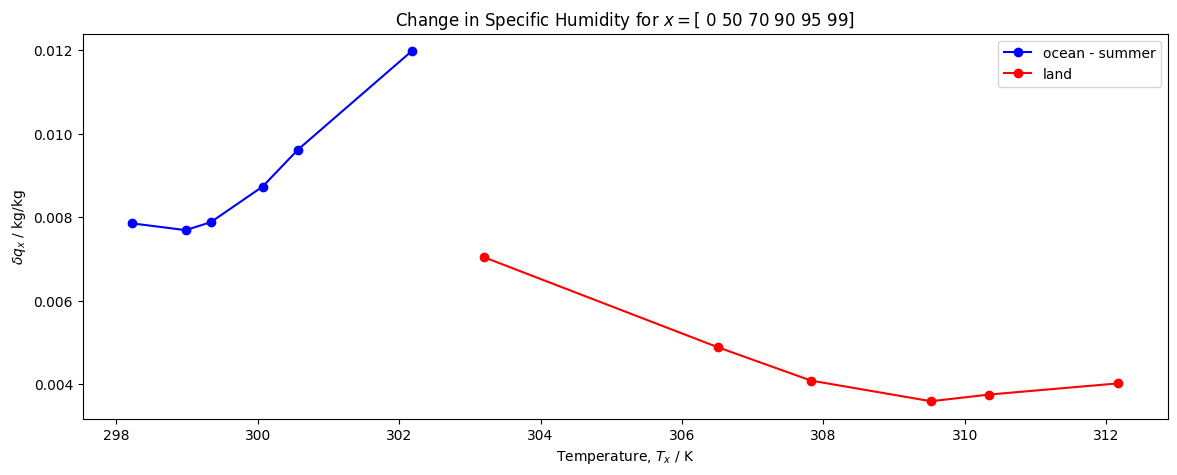

In [9]:
# Plot change in specific humidity for each quantile
fig, ax = plt.subplots(1,1, figsize=(14, 5), sharex=True, sharey=True)
ax.plot(temp_quant['ocean'][0], sphum_quant['ocean'][1]-sphum_quant['ocean'][0], marker='o', color='blue', label='ocean - summer')
ax.plot(temp_quant['land'][0], sphum_quant['land'][1]-sphum_quant['land'][0], marker='o', color='red', label='land')
ax.set_ylabel('$\delta q_x$ / kg/kg')
ax.set_xlabel('Temperature, $T_x$ / K')
ax.set_title(f'Change in Specific Humidity for $x=${quant_plot}')
ax.legend();

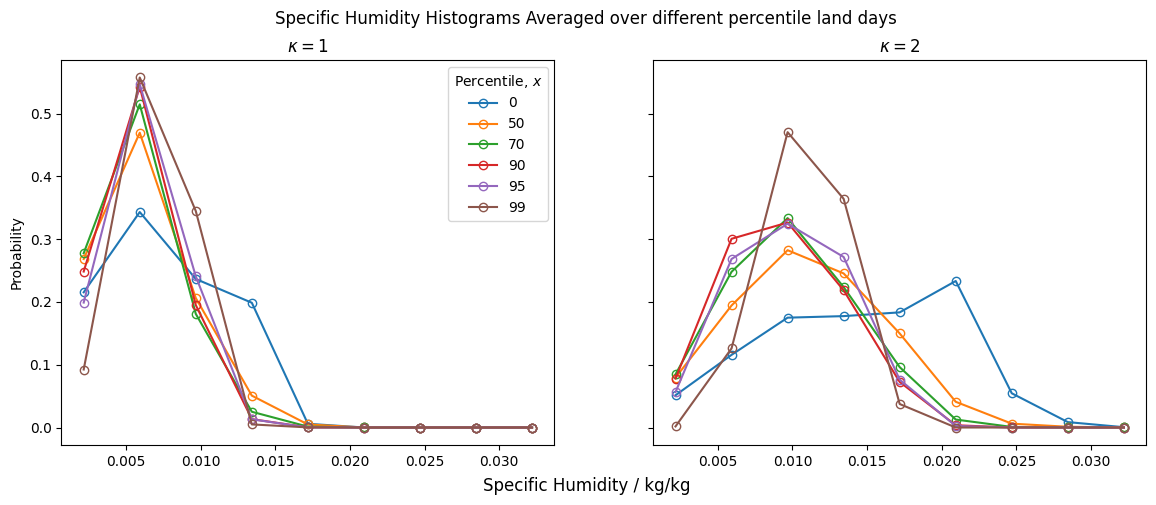

In [10]:
# Plot specific humidity histograms averaged over different quantiles of land surface temperature
# Have first bin be very narrow and centered on 0 so records amount of 0 bucket depths
sphum_bins = np.linspace(ds_all['land'][0].sphum.min(), ds_all['land'][1].sphum.max(), 10)
fig, ax = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
for i in range(n_exp):
    for quant in quant_plot:
        bin_counts = np.histogram(ds_all['land'][i].sphum[get_quant_ind(ds_all['land'][i], quant)], bins=sphum_bins)[0]
        ax[i].plot(np.convolve(sphum_bins, np.ones(2)/2, mode='valid'), bin_counts/np.sum(bin_counts),
                   marker='o', fillstyle='none', label=quant)
        ax[i].set_title(f'$\kappa = {tau_lw[i]}$')
# ax[0].set_yscale('log')
ax[0].legend(title='Percentile, $x$')
ax[0].set_ylabel('Probability')
fig.supxlabel('Specific Humidity / kg/kg')
fig.suptitle('Specific Humidity Histograms Averaged over different percentile land days');

The plot below shows that for days with 0 bucket depth, the specific humidity is also very small.

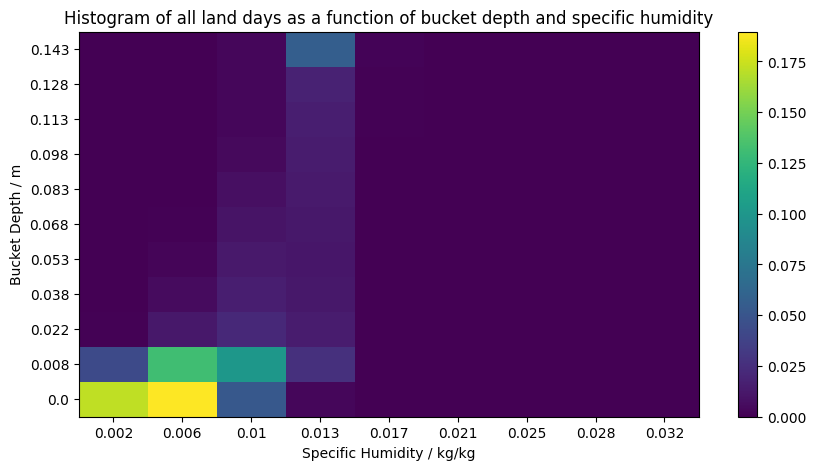

In [11]:
hist = np.histogram2d(ds_all['land'][0].sphum, ds_all['land'][0].bucket_depth, bins=[sphum_bins, bins])[0]

fig, ax = plt.subplots(1,1, figsize=(10, 5))
im = plt.imshow(hist.T/hist.sum(), origin='lower', aspect='auto')
ax.set_xticks(range(hist.shape[0]))
ax.set_xticklabels(np.round(np.convolve(sphum_bins, np.ones(2)/2, mode='valid'), 3))
ax.set_yticks(range(hist.shape[1]))
ax.set_yticklabels(np.round(bin_centres, 3))
fig.colorbar(im)
ax.set_ylabel('Bucket Depth / m')
ax.set_xlabel('Specific Humidity / kg/kg')
ax.set_title('Histogram of all land days as a function of bucket depth and specific humidity');

## Relative Humidity

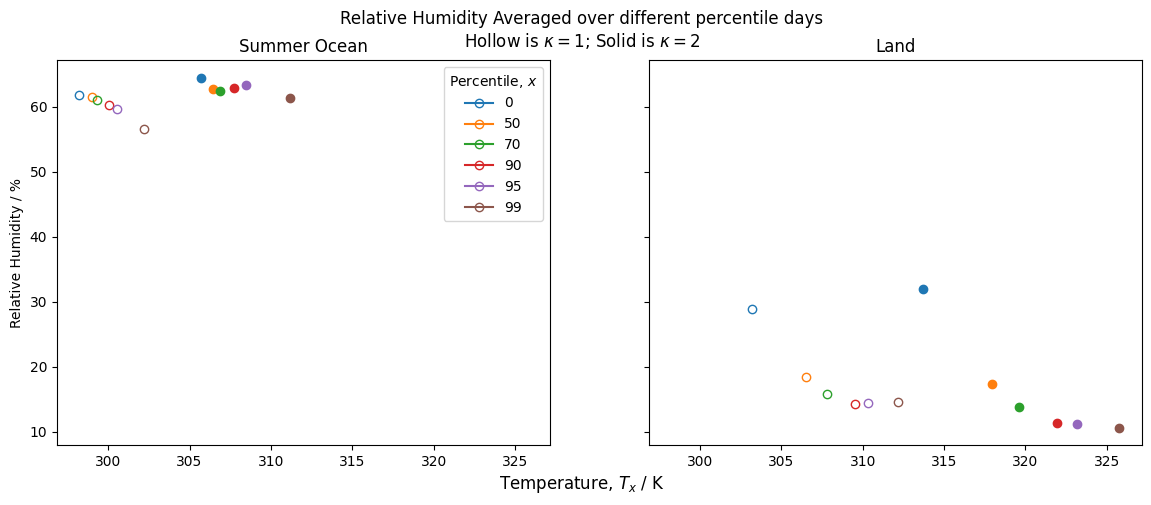

In [12]:
# Compute relative humidity on each individual day and then average over these
# Rather than computing relative humidity from average temperature and average sphum
p_surface = float(ds_summer[0].pfull) * 100
rh_all = {'ocean': [rh_from_sphum(ds_summer[i].sphum, ds_summer[i].temp, p_surface).to_numpy() for i in range(n_exp)],
          'land': [rh_from_sphum(ds_all['land'][i].sphum, ds_all['land'][i].temp, p_surface).to_numpy() for i in range(n_exp)]}
rh_quant = {'ocean': np.zeros((n_exp, len(quant_plot))), 'land': np.zeros((n_exp, len(quant_plot)))}
fig, ax = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
for k, ds_use in enumerate([ds_summer, ds_all['land']]):
    for i in range(n_exp):
        for j, quant in enumerate(quant_plot):
            use_ind = get_quant_ind(ds_use[i], quant)
            rh_quant[surfaces[k]][i, j] = np.mean(rh_all[surfaces[k]][i][use_ind])
            if i == 0:
                ax[k].plot(temp_quant[surfaces[k]][i, j], rh_quant[surfaces[k]][i, j], marker='o', fillstyle='none', label=quant)
            else:
                ax[k].plot(temp_quant[surfaces[k]][i, j], rh_quant[surfaces[k]][i, j], marker='o',
                           color=plt.rcParams['axes.prop_cycle'].by_key()['color'][j])
ax[0].legend(title='Percentile, $x$')
ax[0].set_title('Summer Ocean')
ax[1].set_title('Land')
fig.supxlabel('Temperature, $T_x$ / K')
ax[0].set_ylabel('Relative Humidity / %')
fig.suptitle(f'Relative Humidity Averaged over different percentile days\n'
             f'Hollow is $\kappa = {tau_lw_ref}$; Solid is $\kappa={tau_lw_warm}$');

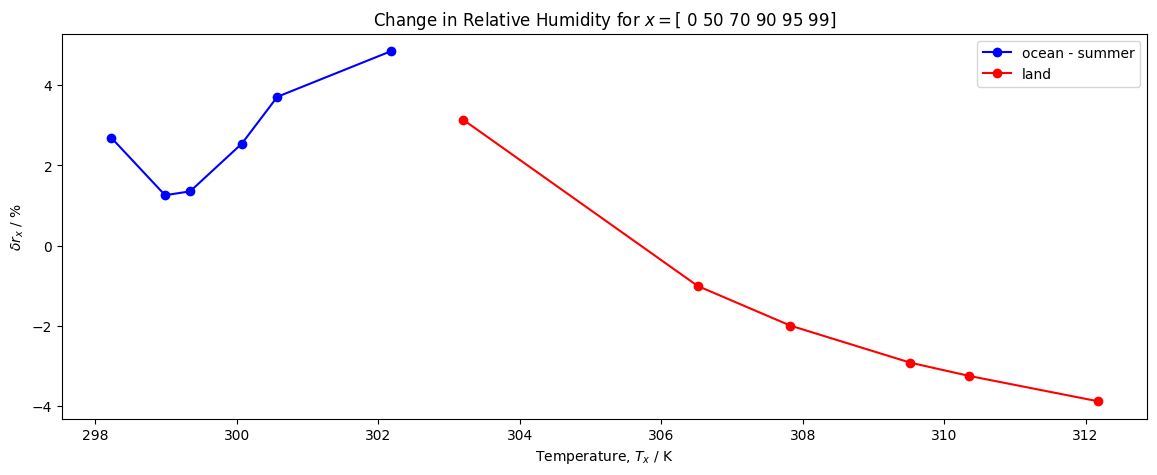

In [13]:
# Plot change in relative humidity for each quantile
fig, ax = plt.subplots(1,1, figsize=(14, 5), sharex=True, sharey=True)
ax.plot(temp_quant['ocean'][0], rh_quant['ocean'][1]-rh_quant['ocean'][0], marker='o', color='blue', label='ocean - summer')
ax.plot(temp_quant['land'][0], rh_quant['land'][1]-rh_quant['land'][0], marker='o', color='red', label='land')
ax.set_ylabel('$\delta r_x$ / %')
ax.set_xlabel('Temperature, $T_x$ / K')
ax.set_title(f'Change in Relative Humidity for $x=${quant_plot}')
ax.legend();

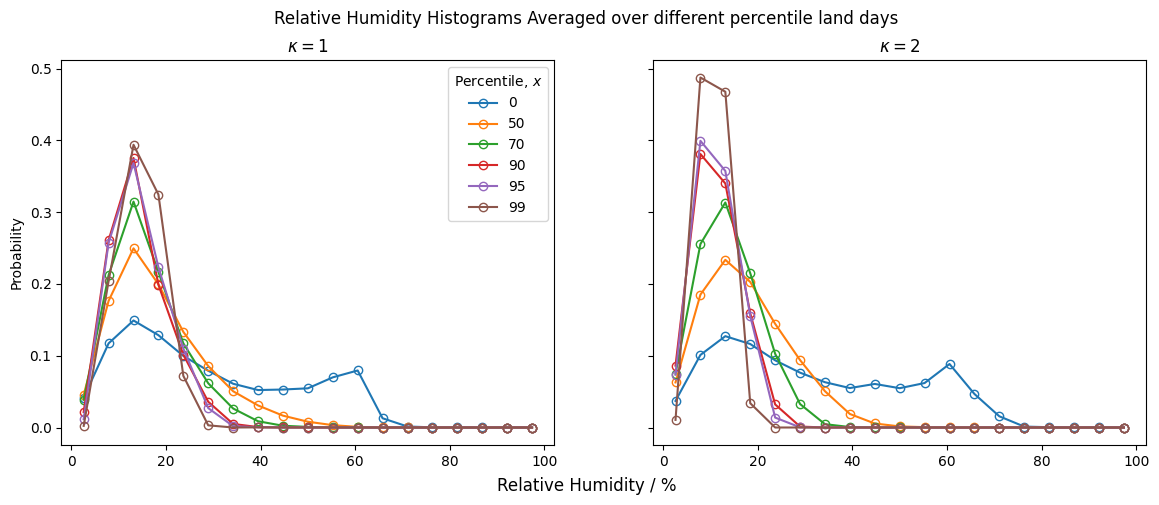

In [14]:
# Plot relative humidity histograms averaged over different quantiles of land surface temperature
# Have first bin be very narrow and centered on 0 so records amount of 0 bucket depths
rh_bins = np.linspace(0, 100, 20)
fig, ax = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
for i in range(n_exp):
    for quant in quant_plot:
        bin_counts = np.histogram(rh_all['land'][i][get_quant_ind(ds_all['land'][i], quant)], bins=rh_bins)[0]
        ax[i].plot(np.convolve(rh_bins, np.ones(2)/2, mode='valid'), bin_counts/np.sum(bin_counts),
                   marker='o', fillstyle='none', label=quant)
        ax[i].set_title(f'$\kappa = {tau_lw[i]}$')
# ax[0].set_yscale('log')
ax[0].legend(title='Percentile, $x$')
ax[0].set_ylabel('Probability')
fig.supxlabel('Relative Humidity / %')
fig.suptitle('Relative Humidity Histograms Averaged over different percentile land days');

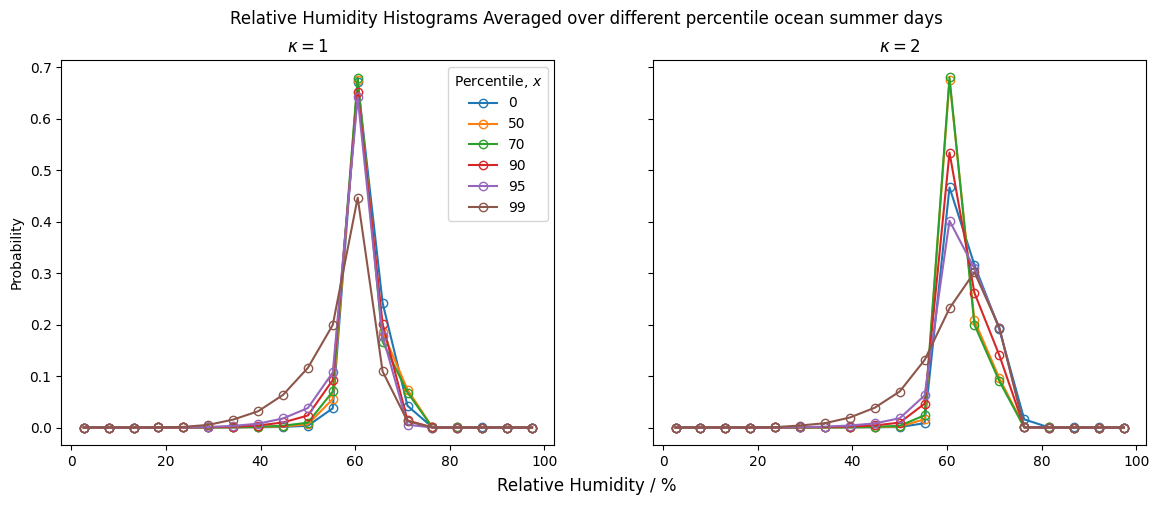

In [15]:
fig, ax = plt.subplots(1,2, figsize=(14, 5), sharex=True, sharey=True)
for i in range(n_exp):
    for quant in quant_plot:
        bin_counts = np.histogram(rh_all['ocean'][i][get_quant_ind(ds_summer[i], quant)], bins=rh_bins)[0]
        ax[i].plot(np.convolve(rh_bins, np.ones(2)/2, mode='valid'), bin_counts/np.sum(bin_counts),
                   marker='o', fillstyle='none', label=quant)
        ax[i].set_title(f'$\kappa = {tau_lw[i]}$')
# ax[0].set_yscale('log')
ax[0].legend(title='Percentile, $x$')
ax[0].set_ylabel('Probability')
fig.supxlabel('Relative Humidity / %')
fig.suptitle('Relative Humidity Histograms Averaged over different percentile ocean summer days');

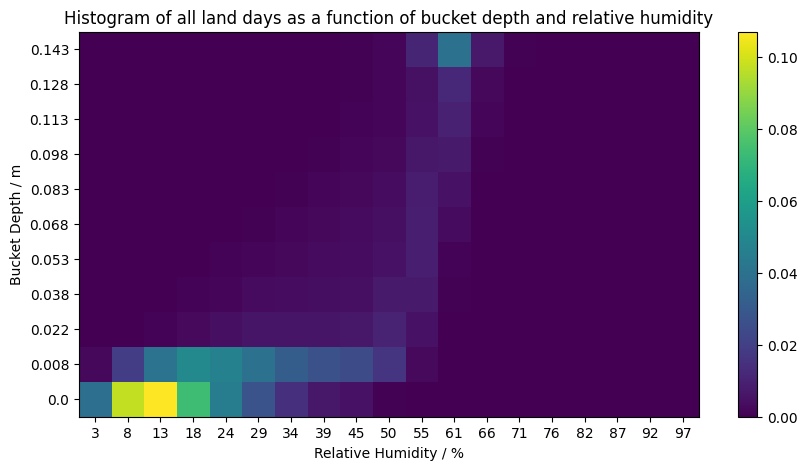

In [16]:
hist = np.histogram2d(rh_all['land'][0], ds_all['land'][0].bucket_depth, bins=[rh_bins, bins])[0]

fig, ax = plt.subplots(1,1, figsize=(10, 5))
im = plt.imshow(hist.T/hist.sum(), origin='lower', aspect='auto')
ax.set_xticks(range(hist.shape[0]))
ax.set_xticklabels(np.round(np.convolve(rh_bins, np.ones(2)/2, mode='valid'), 0).astype(int))
ax.set_yticks(range(hist.shape[1]))
ax.set_yticklabels(np.round(bin_centres, 3))
fig.colorbar(im)
ax.set_ylabel('Bucket Depth / m')
ax.set_xlabel('Relative Humidity / %')
ax.set_title('Histogram of all land days as a function of bucket depth and relative humidity');